<small><i>This notebook was put together by [Wesley Beckner](http://wesleybeckner.github.io/).</i></small>

In [7]:
###setup
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pylab as plp
import pandas as pd
from itertools import cycle
import scipy
#import pymc
import random
import sklearn
from sklearn.gaussian_process import GaussianProcess
from sklearn.preprocessing import StandardScaler, RobustScaler
from pylab import *
from scipy import *
from scipy import optimize
from scipy.optimize import curve_fit
def reject_outliers_med(data, m = 3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def reject_outliers(data, m = 3.):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

def analyticalCDF(xdata,A,alpha,tau1,tau2):
    return A * alpha * tau1 * (1-exp(-xdata/tau1)) + A * (1-alpha) * tau2 * (1-exp(-xdata/tau2))
    

def visc_calc(data):
    ##########
    # Import modules
    ##########    
#     from pylab import *
#     from scipy import *
#     from scipy import optimize
#     from scipy.optimize import curve_fit
    ##########
    # Compute the running standard deviations + averages
    ##########
    bfit=[]
    afit=[]
    std = []
    avg = []
    for i in range(2500):
        std.append(np.std(data.iloc[i,:]))
        avg.append(np.average(data.iloc[i,:]))
    ##########
    # Log data
    ##########
    ydata = std[1:]
    xdata = np.arange(1,len(std[1:])+1,1)*1E-2
    logy = np.log10(ydata)
    logx = np.log10(np.arange(1,len(ydata)+1,1)*1E-2)
    logyerr = np.std(ydata) / ydata
    ##########
    # Fit that func and luv it
    ##########
    fitfunc = lambda p, x: p[0] + p[1] * x   #target function
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err #distance to the target function
    pinit = [1.0, -1.0] #initial guess for the parameters we are solving
    out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1) #solve 'em
    pfinal = out[0]
    covar = out[1]
    index = pfinal[1]
    amp = 10.0**pfinal[0]
    indexErr = sqrt( covar[0][0] ) 
    ampErr = sqrt( covar[1][1] ) * amp
    bfit.append(pfinal[1])
    afit.append(pfinal[0])
    ##########
    # Find the cutoff for the double exponential fit
    ##########
    powerlaw = lambda x, amp, index: amp * (x**index)
    stdfit = powerlaw(xdata, amp, index)
    for i in range(1,2499):
        if stdfit[i] >= avg[i]*0.4:
            tcut=i
    ##########
    # Log data
    ##########
    ydata = avg[1:tcut]
    xdata = np.arange(1,len(avg[1:tcut])+1,1)*1E-2
    logy = np.log10(ydata)
    logx = np.log10(np.arange(1,len(avg[1:])+1,1)*1E-2)
    logyerr = np.std(ydata) / ydata
    ##########
    # Fit that func and luv it
    ##########
    taufit, pcov = curve_fit(analyticalCDF, xdata, ydata, method='dogbox', sigma=(1./((xdata)**bfit)),absolute_sigma=False,\
                        bounds=([-1*np.inf, 0, -1*np.inf, -1*np.inf], [np.inf, 1, np.inf, np.inf]))
    print("calculated viscosity", analyticalCDF(xdata, taufit[0], taufit[1], taufit[2], taufit[3], )[-1])
    return analyticalCDF(xdata, taufit[0], taufit[1], taufit[2], taufit[3], )[-1]
   
###PREPARE DATA
lines = ["-","--","-."]
marker = ['.','v','^','<','>']#,'8','s', '+', '.', 'o', '*','8','s','.', 'o', '*'
linecycler = cycle(lines)
markercycler = cycle(marker)

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 3,
    'axes.labelsize': 8,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
   }
plt.rcParams.update(params)

params = {
    'lines.markersize' : 12,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
   }
plp.rcParams.update(params)

<a id='top'></a>
# Taken from Maginn 2015

![](maginnimage.gif)

Time-Decomposition Method for Viscosity Calculation. The shear viscosity was calculated by following procedure:

1. Generate N independent NVT trajectories at a given temperature;
2. For each [trajectory](#data load), calculate the shear viscosity based on the Green−Kubo relation (eq 1);
3. Calculate the **average of the running integrals** over N trajectories ⟨η(t)⟩ and the standard deviation, which is a function of time
4. Fit the standard deviation to a [power law function](#t**b)
5. Fit the averaged running integral by the [double-exponential function](#dexp) (eq 2) for the time period up to tcut with the weight 1/tb, where b is the fitting result from step (4) and [tcut](#tcut) can be decided from the relation between η and σ(t). We found that the time when σ(t)is about 40% of ⟨η(t)⟩ is a good choice. Take the long time limit of the fitted double-exponential function as the calculated viscosity;
6. Increase N and repeat steps (1)−(5) until the change in the calculated viscosity in step (5) from previous cycle is smaller than a tolerance.
7. [plot viscosities](#visc)
8. [check for convergence](#convergence)

<a id='data load'></a>

# Load Einstein Relations

[back to top](#top)

In [2]:
data=pd.read_csv('BDM.TF2.350.maginn.einsteinvisc', header=None)

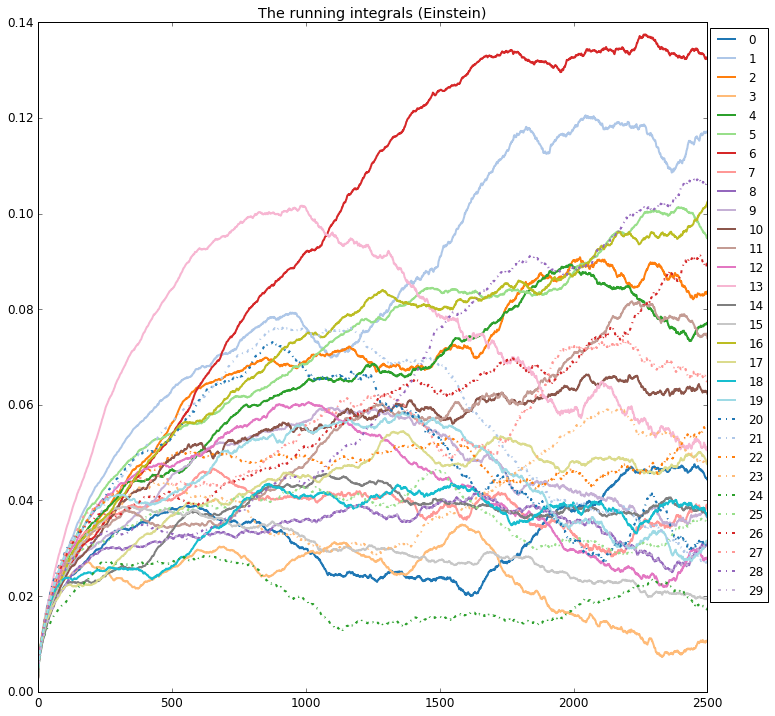

In [6]:
fig=plt.figure(figsize=(12,12), dpi=300)
ax1 = fig.add_subplot(111)
for i in range(30):
    if i < 20:
        ax1.plot(data.iloc[:,i], linestyle='-', lw=2, c=tableau20[i])
    else:
        ax1.plot(data.iloc[:,i], linestyle='-.', lw=2, c=tableau20[i-20])
    plt.legend(bbox_to_anchor=[1.1,1]) 
    plt.title('The running integrals (Einstein)')
fig.savefig(filename='maginn1.png', bbox_inches='tight', format='png') 

<a id='t**b'></a>

# Find t**b

[back to top](#top)

b's are stored in numpy files from the cell below. Skip this cell if not re-calculating b-values

[0.59960839924763487]


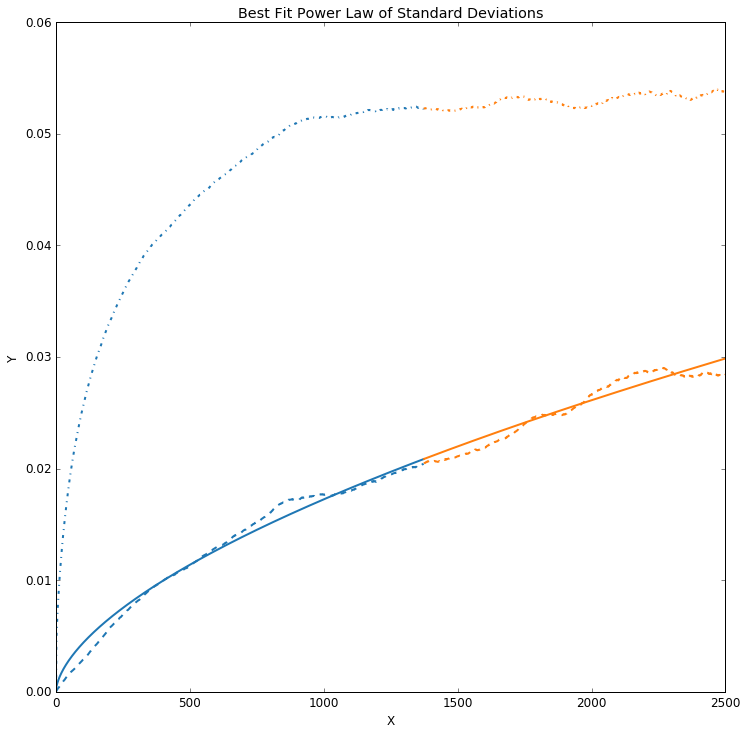

In [5]:
###vary initial guess, check fit
from pylab import *
from scipy import *
from scipy import optimize
powerlaw = lambda x, amp, index: amp * (x**index)
prop = ['dens', 'Cp', 'visc']
bfit=[]
afit=[]
fig=plt.figure(figsize=(12,12), dpi=300)
ax1 = fig.add_subplot(111)

##########
# Compute the running standard deviations + averages
##########
std = []
avg = []
for i in range(2500):
    std.append(np.std(data.iloc[i,:]))
    avg.append(np.average(data.iloc[i,:]))
##########
# Log data
##########
ydata = std[1:]
xdata = np.arange(1,len(std[1:])+1,1)*1E-2
logy = np.log10(ydata)
logx = np.log10(np.arange(1,len(ydata)+1,1)*1E-2)
logyerr = np.std(ydata) / ydata
##########
# Fit that func and luv it
##########
fitfunc = lambda p, x: p[0] + p[1] * x   #target function
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err #distance to the target function
pinit = [1.0, -1.0] #initial guess for the parameters we are solving
out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1) #solve 'em
pfinal = out[0]
covar = out[1]
index = pfinal[1]
amp = 10.0**pfinal[0]
indexErr = sqrt( covar[0][0] ) 
ampErr = sqrt( covar[1][1] ) * amp
bfit.append(pfinal[1])
afit.append(pfinal[0])
print bfit
##########
# Plotting data
##########
ax1.plot(xdata[:1373]*1E2, powerlaw(xdata, amp, index)[:1373], linestyle='-', lw=2, c=tableau20[0])     # Fit
ax1.plot(xdata[:1373]*1E2, ydata[:1373], linestyle='--', lw=2, c=tableau20[0])  # Data
ax1.plot(xdata[:1373]*1E2, avg[0:1373], linestyle='-.', lw=2, c=tableau20[0])
ax1.plot(xdata[1374:]*1E2, powerlaw(xdata, amp, index)[1374:], linestyle='-', lw=2, c=tableau20[2])     # Fit
ax1.plot(xdata[1374:]*1E2, ydata[1374:], linestyle='--', lw=2, c=tableau20[2])  # Data
ax1.plot(xdata[1373:]*1E2, avg[1374:], linestyle='-.', lw=2, c=tableau20[2])
title('Best Fit Power Law of Standard Deviations')
xlabel('X')
ylabel('Y')
fig.savefig(filename='maginn2.png', bbox_inches='tight', format='png') 

<a id='tcut'></a>
# Find t_cut

[back to top](#top)

In [7]:
###find tcut
###numpy.where 
stdfit = powerlaw(xdata, amp, index)
for i in range(1,2499):
    if stdfit[i] >= avg[i]*0.4:
        tcut=i
        print("tcut ", i)
        print("bfit ", bfit)
        break

('tcut ', 1380)
('bfit ', [0.59960839924763487])


<a id='dexp'></a>
# Fit the double exponential


[back to top](#top)

salt 		 BMI_TF2 at 350k
fit parameters 		[ 0.06898013  0.13264533  3.85307226  0.30881581]
calculated viscosity 0.0527479346797


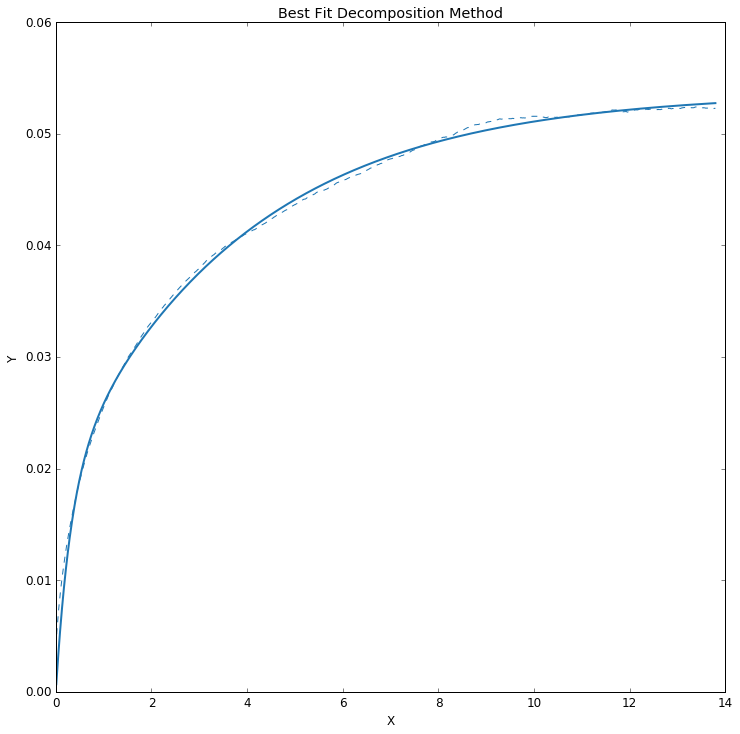

In [9]:
from pylab import *
from scipy import *
from scipy import optimize
from scipy.optimize import curve_fit
powerlaw = lambda x, amp, index: amp * (x**index)
fig=plt.figure(figsize=(12,12), dpi=300)
ax1 = fig.add_subplot(111)
##########
# Log data
##########
ydata = avg[1:tcut]
xdata = np.arange(1,len(avg[1:tcut])+1,1)*1E-2
logy = np.log10(ydata)
logx = np.log10(np.arange(1,len(avg[1:])+1,1)*1E-2)
logyerr = np.std(ydata) / ydata
##########
# Fit that func and luv it
##########
def analyticalCDF(xdata,A,alpha,tau1,tau2):
    return A * alpha * tau1 * (1-exp(-xdata/tau1)) + A * (1-alpha) * tau2 * (1-exp(-xdata/tau2))

taufit, pcov = curve_fit(analyticalCDF, xdata, ydata, method='dogbox', sigma=(1./((xdata)**bfit)),absolute_sigma=False,\
                    bounds=([-1*np.inf, 0, -1*np.inf, -1*np.inf], [np.inf, 1, np.inf, np.inf]))
print "salt \t\t BMI_TF2 at 350k"
print "fit parameters \t\t" ,taufit
print "calculated viscosity", analyticalCDF(xdata, taufit[0], taufit[1], taufit[2], taufit[3], )[-1]
##########
# Plotting data
##########
ax1.plot(xdata, analyticalCDF(xdata, taufit[0], taufit[1], taufit[2], taufit[3], ), linestyle='-', lw=2, c=tableau20[0])
ax1.plot(xdata, ydata, linestyle='--', lw=1, c=tableau20[0])  # Data
plt.legend(bbox_to_anchor=[1,1]) 
title('Best Fit Decomposition Method')
xlabel('X')
ylabel('Y')
fig.savefig(filename='maginn3.png', bbox_inches='tight', format='png') 

In [10]:
###Using functions
params = bfit_func(data)
visc = visc_calc(*params)

NameError: name 'bfit_func' is not defined

<a id='visc'></a>
# Viscosity plots


[back to top](#top)

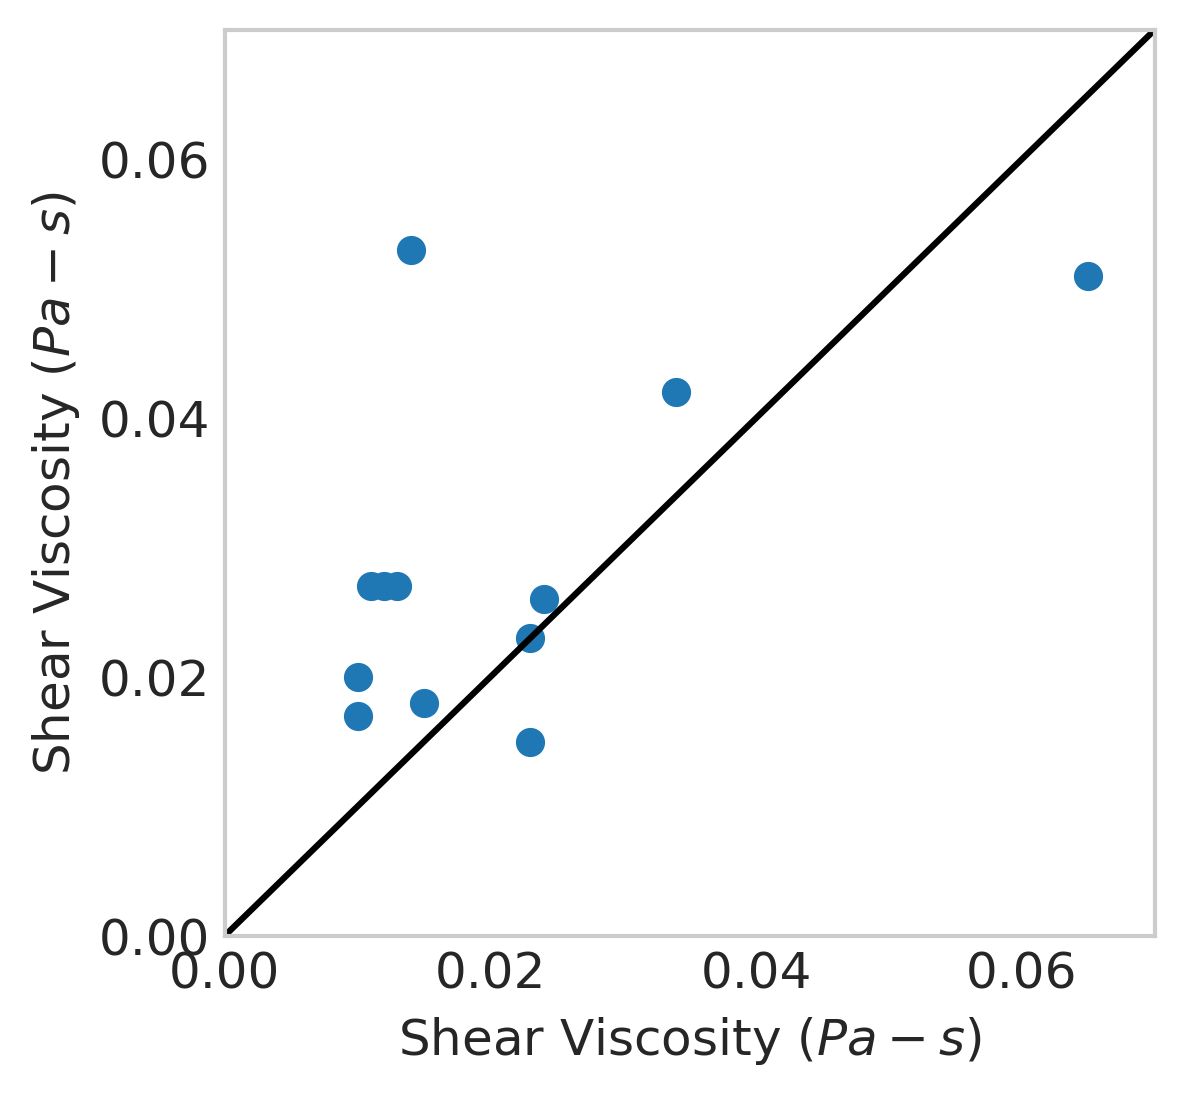

In [25]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(4,4), dpi=300)
    ax = fig.add_subplot(111)
    df=pd.read_csv('combinedviscosity.csv', header=0)
    ##################
    #START PLOTTING VISCOSITIES
    ##################
    k=0
    for i,p in enumerate(df[['cation']].values): 
        try:   
            ax.plot(myround(df[['viscosity_exp_350']].values[i][0], 0.001)\
                    ,myround(df[['viscosity_maginn_einstein']].values[i][0], 0.001)\
                    , linestyle='-', lw=2, marker='.', c=tableau20[0]\
                    , label=(df[['cation']].values[i][0],df[['anion']].values[i][0]))
            #plt.legend(bbox_to_anchor=[1,1]) 
            k=k+1
        except ValueError:
            pass
    ##################
    #MAKE PLOT ADJUSTMENTS
    ##################
    plt.rc
    ax.set_xlim(0.01,0.07)
    ax.set_ylim(0.01,0.07)
    ax.plot([0,0.07], [0,0.07], linestyle="-", label=None, c="black")
    ax.set_yticks(np.arange(0.0,0.07,0.02))
    ax.set_xticks(np.arange(0.0,0.07,0.02))
    ax.set_xlabel('Shear Viscosity $(Pa-s)$')# (Exp)')
    ax.set_ylabel('Shear Viscosity $(Pa-s)$')# (Calculated)')
    plt.grid()
    fig.subplots_adjust(wspace=.4)
fig.savefig(filename='maginn.pdf', bbox_inches='tight', format='pdf') 

<a id='convergence'></a>
# Convergence plots

[back to top](#top)

0.0266958086026


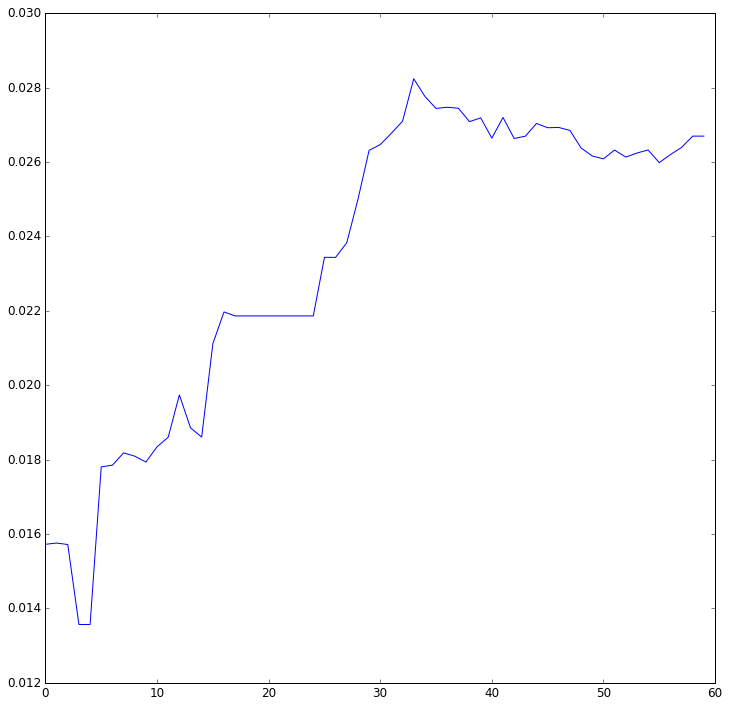

In [13]:
name="HMI.TF2"
data = np.load("%s_convergence.npy" % name)
fig=plt.figure(figsize=(12,12), dpi=300)
ax1 = fig.add_subplot(111)
ax1.plot(data)
print(data[-1])
fig.savefig(filename='maginn4.png', bbox_inches='tight', format='png') 

failed attempt, setting convergence to prior value
calculated viscosity 0.132921544065
calculated viscosity 0.114192136436
calculated viscosity 0.0977713715781
calculated viscosity 0.0867136910997
calculated viscosity 0.0875005464354
calculated viscosity 0.107852005308
calculated viscosity 0.106492933801
calculated viscosity 0.104024915697
calculated viscosity 0.115547005049
calculated viscosity 0.113073582813
calculated viscosity 0.114129434081
calculated viscosity 0.115114533919
calculated viscosity 0.143343589539
calculated viscosity 0.138491923211
calculated viscosity 0.149438132543
calculated viscosity 0.147170735993
failed attempt, setting convergence to prior value
calculated viscosity 0.145078112567
failed attempt, setting convergence to prior value
calculated viscosity 0.138861267918
calculated viscosity 0.143731773756
failed attempt, setting convergence to prior value
failed attempt, setting convergence to prior value
calculated viscosity 0.136758582294
calculated viscosity 0

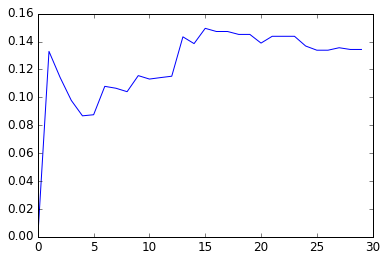

In [2]:
name="BMI.TF2"
data=pd.read_csv('%s.298.maginn.einsteinvisc' % name, header=None)
j = data.shape[1]
convergence = np.zeros(j)
for i in range(j):
    try:
        convergence[i] = visc_calc(data.ix[:,:(i+1)])
    except:
        convergence[i] = convergence[i-1]
        print("failed attempt, setting convergence to prior value")
        pass
plt.plot(convergence)

#np.save("%s_convergence" % name,convergence)

### Residence time calculator from resid.txt file, that's an output from getresid.tcl 

In [ ]:
# RESIDENCE TIME CALCULATOR


# by Parashara Shamaprasad and Karl Oleson and Kayla!

#Run wrapper.sh to get resid.txt

#in you resid.txt file, you will need to first add a space before each line (:1,[#of frames]s/^/ [<-space]))
# -->You will also need to add a blank line to the bottom of the resid.txt document

# This program is intended to read the file produced by Kayla's Occupancy wrapper.sh script
# output the residence (or correlation) time of tannins.

#this script treats the end of the simulation as the end of a binding event (even though it may go on longer if the simulation were extended)

#Double check that the rows in the output file match up with the residues you think they do

#------------#
# INPUT DATA #
#------------#

# specify the input distance file (this needs to be whatever you previosly named it):
in_file = 'residYYY.txt'

# specify the output file for the residence times of the ions (this file will be created)
res_file = 'outputZZZ.txt'

#--------------#
# PROGRAM DATA #
#--------------#

# converts inputfile into list/array
def read_lines(line):
    tokens = line.split()
    lineout = [int(item) for item in tokens]
    return lineout

# converts the distance array into a matrix of on/off states based on
# whether the ion is within the cutoff
def binary_matrix(array):
    output = [[0 for i in range(36)] for j in range(len(array)+1)]
    for row in range(len(array)):
        output[row][0] = row
        for col in range(len(array[row])):
            a = array[row][col]
            output[row][a] = 1
    return output

# finds the residence time for each interaction.
def residence(binlist):
    counting = False # is the counter running?
    output = [["res","times"]] # list of correlation times
    row = 0
    for col in range(1,len(binlist[row])): # for every ion
        output.append([col])
        count = 0
        counting = False
        row = 0
        while row < (len(binlist)): # for every frame
           # counting procedure for each possible scenario
	# is this the first binding event in a string?
            if (counting == False) and (binlist[row][col] == 1):
                counting = True
                count = 1
	# is this the continuation of a binding event
            elif (counting == True) and (binlist[row][col] == 1) and (row < len(binlist) - 2):
                count += 1
	#is this a binding site and at the last row with relevant info
            elif (counting == True) and (binlist[row][col] == 1) and (row < len(binlist) - 1):
                count += 1
                counting = False
                output[col].append(count)
                count = 0
	#is it not binding anymore
            elif (counting == True and binlist[row][col] == 0):
                counting = False
                output[col].append(count)
                count = 0
	#was it previously not binding
            else:
                counting = False
            row += 1
    return output

In [ ]:
# Arranging residence time values for plotting 
f = open('resTime.txt','r')
restimes20=[]
for x in f:
    x = [int(i) for i in x.split()]
    restimes20.append(np.mean(x))
f.close()
restimes20=np.nan_to_num(restimes20)
len(restimes20)
restimesPLA = pd.Series(restimes20)
restimesPLA.sort_values(ascending=False)

In [ ]:
# Create heat map from occupancy text file 
fullTraj = pd.read_table("occ_BSA1ns.txt", delimiter=' ', index_col=0)
data2 = [go.Heatmap(z=fullTraj.T.values.tolist(), colorscale='Viridis')]
py.iplot(data2, filename='BSA_heatmap')